# Syntactic Knowledge Acquisition

In [1]:
import logging
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForMaskedLM

# suppress warnings
logging.getLogger("transformers").setLevel(logging.ERROR)

In [2]:
def evaluate(sentence, word, checkpoint):
    """
    - INPUT: 
        sentence: a sentence with a masked token w
        word: the desired label for the masked token
        checkpoint: a pretrained model checkpoint
    - OUTPUT: probability and surprisal of the desired label at the masked position 
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    model = AutoModelForMaskedLM.from_pretrained(checkpoint).to(device)

    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model)

    inputs = tokenizer(sentence, return_tensors='pt').to(device)
    label_id = tokenizer.convert_tokens_to_ids(word)
    
    model.eval()
    with torch.no_grad():
        output = model(**inputs)
        logits = output.logits
    
    probs = F.softmax(logits, dim=-1)

    # probability and surprisal of the desired label at the masked position
    mask_token_index = torch.where(inputs['input_ids'][0] == tokenizer.mask_token_id)[0]
    label_prob = probs[0, mask_token_index, label_id]    
    surprisal = -torch.log2(label_prob).item()

    return label_prob.item(), surprisal

In [3]:
def word_evaluation(sentence_pair, sent_id, model, df, description=''):
    """
    INPUT:
        - sentence_pair: a tuple of tokenized strings
        - model: a Google Multiberts model from Hugging Face
    OUTPUT:
        - a Pandas data frame containing the probability of the label and surprisal of the model at each step
    """
    sent_1, sent_2 = sentence_pair

    # extracting the different words as the labels
    label_1 = ''.join(filter(lambda word: word not in sent_2.split(), sent_1.split()))
    label_2 = ''.join(filter(lambda word: word not in sent_1.split(), sent_2.split()))

    masked_sent = ' '.join('[MASK]' if word == label_1 else word for word in sent_1.split())

    steps = list(range(0, 200_000, 20_000)) + list(range(200_000, 2_100_000, 100_000))
    for step in steps:
        checkpoint = model + f'-step_{step//1000}k'
        for label in [label_1, label_2]:
            probability, surprisal = evaluate(masked_sent, label, checkpoint)
            label_data = {'step': step,
                          'sent_id': sent_id, 
                          'masked_sent': masked_sent, 
                          'label': label,
                          'correct': label == label_1,  # the first label is the correct label 
                          'probability': probability, 
                          'surprisal': surprisal,
                          'description': description}        
            df = df.append(label_data, ignore_index=True)

    return df

In [4]:
def corpus_evaluation(data_df, model):
    results_df = pd.DataFrame(columns=['step', 'sent_id', 'masked_sent', 'label', 'correct', 'probability', 'surprisal'])
    sent_id = 0
    for column in data_df.columns:
        for sentence_pair in data_df[column].tolist():
            results_df = word_evaluation(sentence_pair, sent_id, model, results_df, description=column)
            sent_id += 1
    return results_df

In [5]:
def plot_single_pair(df):
    plt.style.use('ggplot')
    fig, axs = plt.subplots(2, figsize=(8, 8))

    labels = df['label'].unique().tolist()

    for label in labels:
        # plot for surprisals
        df[df['label'] == label].plot(x='step', y='surprisal', logx=True, title='Surprisal', ax=axs[0], label=label)

        # plot for probabilities
        df[df['label'] == label].plot(x='step', y='probability', logx=True, title='Probability', ax=axs[1], label=label)

    axs[0].legend()
    axs[1].legend()

    plt.tight_layout()
    plt.show()

In [6]:
def plot_full_corpus(df):
    plt.style.use('ggplot')
    fig, axs = plt.subplots(2, figsize=(12, 8))

    df = df.sort_values('step')
    correct = df[df['correct'] == True]
    incorrect = df[df['correct'] == False]

    # plot for probabilities
    correct.plot(x='step', y='probability', logx=True, kind='scatter', color='green', alpha=0.2, ax=axs[0], label='individual correct')
    correct.groupby('step').probability.mean().plot(x='step', ylabel='probability', logx=True, color='green', linestyle='--', ax=axs[0], label='average correct', title='Probability of Correct vs Incorrect Labels')
    incorrect.plot(x='step', y='probability', logx=True, kind='scatter', color='red', alpha=0.2, ax=axs[0], label='individual incorrect')
    incorrect.groupby('step').probability.mean().plot(x='step', ylabel='probability', logx=True, color='red', linestyle='--', ax=axs[0], label='average incorrect')

    # plot for surprisals
    correct.plot(x='step', y='surprisal', logx=True, kind='scatter', color='green', alpha=0.2, ax=axs[1], label='individual correct')
    correct.groupby('step').surprisal.mean().plot(x='step', ylabel='surprisal', logx=True, color='green', linestyle='--', ax=axs[1], label='average correct', title='Surprisal of Correct vs Incorrect Labels')
    incorrect.plot(x='step', y='surprisal', logx=True, kind='scatter', color='red', alpha=0.2, ax=axs[1], label='individual incorrect')
    incorrect.groupby('step').surprisal.mean().plot(x='step', ylabel='surprisal', logx=True, color='red', linestyle='--', ax=axs[1], label='average incorrect')

    axs[0].legend(loc='upper left', bbox_to_anchor=(1.0, 1))
    axs[1].legend(loc='upper left', bbox_to_anchor=(1.0, 1))

    # plt.grid('--')
    plt.tight_layout()
    plt.show()

---

In [ ]:
with open('sample_data/lm_syneval/simple_agrmt.pickle', 'rb') as f:
    simple_agrmt = pd.DataFrame(pickle.load(f))

simple_agrmt

In [ ]:
%%time 

model = 'google/multiberts-seed_0'
results_df = corpus_evaluation(simple_agrmt, model)
results_df.to_csv('results/simple_agrmt_results.csv', sep='\t', index=False)

---
### Analysis of the results


In [7]:
results_df = pd.read_csv('results/simple_agrmt_results.csv', sep='\t')

# in every sentence pair (same sent_id) the first label is the correct label. 
results_df.insert(results_df.columns.get_loc('label') + 1, 'correct', results_df.groupby(['step', 'sent_id']).cumcount() % 2 == 0)
results_df

,step,sent_id,masked_sent,label,correct,probability,surprisal,description
0,0,0,the author [MASK],laughs,True,1.048201e-05,16.541725,sing_MS_MV
1,0,0,the author [MASK],laugh,False,5.473720e-05,14.157119,sing_MS_MV
2,20000,0,the author [MASK],laughs,True,7.257230e-07,20.394077,sing_MS_MV
3,20000,0,the author [MASK],laugh,False,3.766840e-07,21.340141,sing_MS_MV
4,40000,0,the author [MASK],laughs,True,6.418337e-06,17.249369,sing_MS_MV
...,...,...,...,...,...,...,...,...
8115,1800000,139,the consultants [MASK] short,is,False,8.593616e-03,6.862519,plur_MS_MV
8116,1900000,139,the consultants [MASK] short,are,True,6.057420e-02,4.045153,plur_MS_MV
8117,1900000,139,the consultants [MASK] short,is,False,4.686356e-03,7.737318,plur_MS_MV
8118,2000000,139,the consultants [MASK] short,are,True,5.674843e-02,4.139276,plur_MS_MV


['the surgeons [MASK] short']


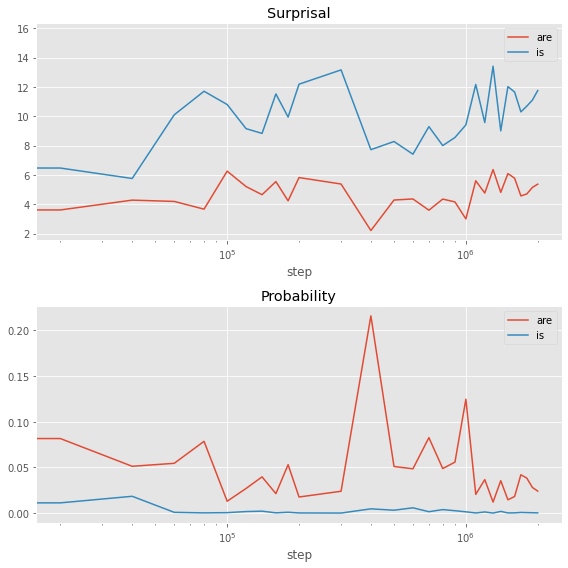

In [8]:
print(results_df[results_df['sent_id'] == 90]['masked_sent'].unique())
plot_single_pair(results_df[results_df['sent_id'] == 90])

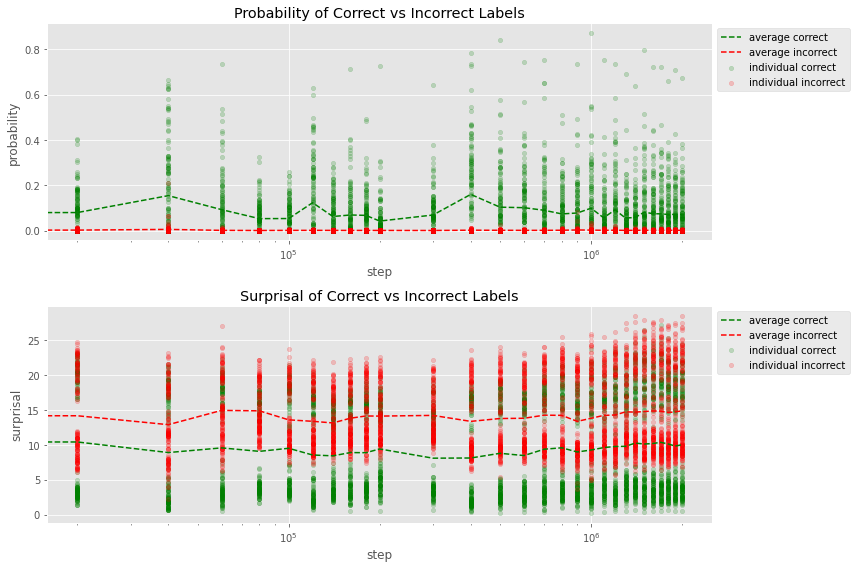

In [11]:
plot_full_corpus(results_df)